In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 20s 253ms/step - loss: 0.2159 - root_mean_squared_error: 0.4647 - val_loss: 0.1574 - val_root_mean_squared_error: 0.3967
Epoch 2/50
53/53 [==============================] - 12s 225ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2738
Epoch 3/50
53/53 [==============================] - 12s 227ms/step - loss: 0.0718 - root_mean_squared_error: 0.2679 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2541
Epoch 4/50
53/53 [==============================] - 13s 245ms/step - loss: 0.0641 - root_mean_squared_error: 0.2533 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2349
Epoch 5/50
53/53 [==============================] - 13s 244ms/step - loss: 0.0542 - root_mean_squared_error: 0.2329 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2111
Epoch 6/50
53/53 [==============================] - 12s 226ms/step - loss: 0.0439 - root_mean_squared_error: 0.2094 - val_loss: 0.0302 

53/53 [==============================] - 2s 33ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 30/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 31/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 32/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 33/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 34/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0070 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.89801363547643 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

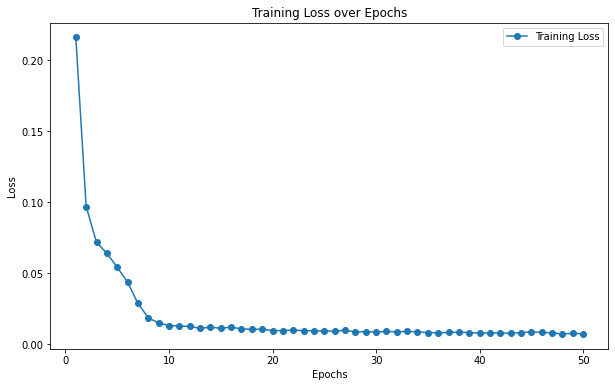

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

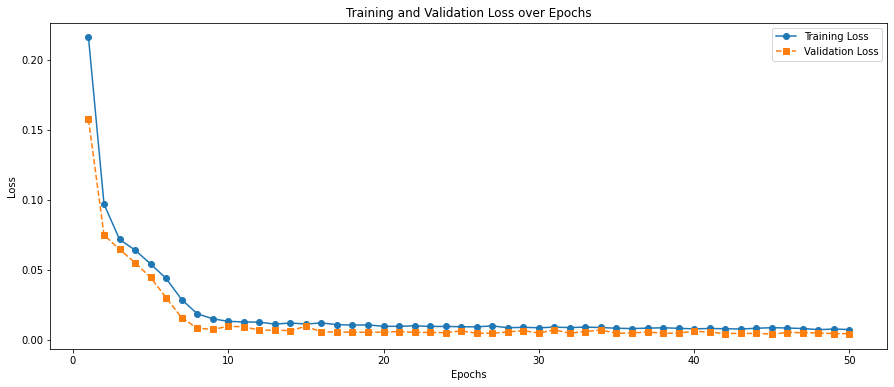

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 18ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06687323049122315
MAE : 0.05301407122393099


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,6.024410e+05,635624.004
1,4.940635e+05,460009.672
2,5.966466e+05,610848.036
3,8.664011e+05,819257.445
4,1.214657e+06,1129627.707
5,1.511432e+06,1463383.236
6,1.730368e+06,1614536.727
7,1.881270e+06,1862498.612
8,1.932863e+06,2099349.296
9,1.857767e+06,1981614.046


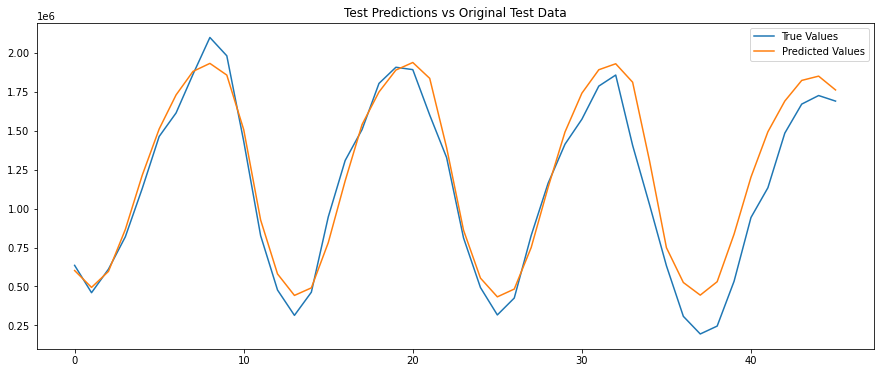

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

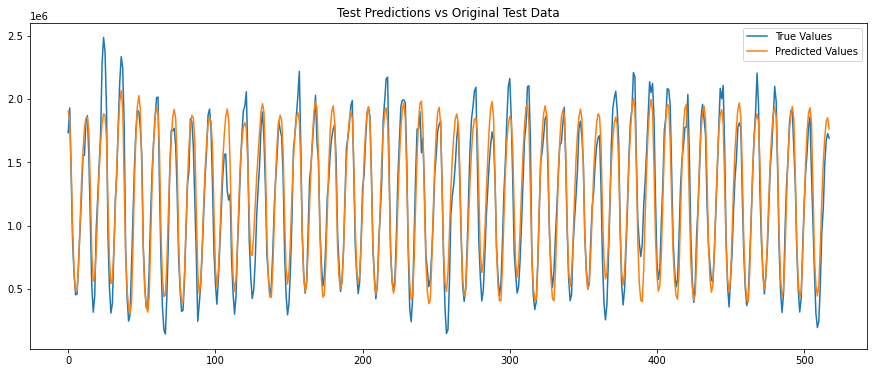

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()